# Welcome to the Batting Model

In [4]:
import pandas as pd
import numpy as np

Any table on baseball-referece can be easily read into a pandas dataframe for analysis.

First mouse over the Share & More menu and then click on the Emed this table option.

You will get a pop up with some html/js code in it, we'll need to grab the "src" part of the code, the part that starts with "widget" all we have to do is put "http:" in front.

screenshot:
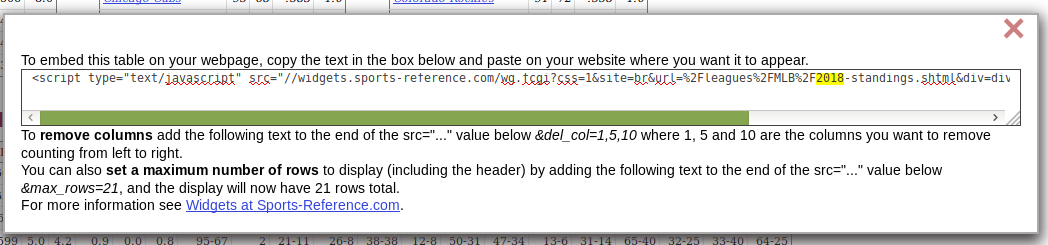

Typically in this url you will see a year(or some other variable) that you can change to get that year's version of the table that you are looking at.

The rest of this code shows you how to scrape the detail standings data for years 1980 through 2018. The big assumption here is that you are comfortable with, or are willing to put in the effort yourself to learn, python.

Feel free to adapt it to your needs.

In [3]:
url = "http://widgets.sports-reference.com/wg.fcgi?css=1&site=br&url=%2Fleagues%2FMLB%2F{}-standings.shtml&div=div_expanded_standings_overall"

In [ ]:
# loop through years and pull data for each year using the read_html method of pandas. we're going to concat these frames together into one large dataset
all_years = []
for year in range(1980,2019):
  print("getting year", year)
  df = pd.read_html(url.format(year))[0].iloc[:-1] #don't include the totals row
  df["year"] = year
  all_years.append(df)

In [ ]:
#put all the years together
all_years_df = pd.concat(all_years)